# Assignment 1: Hidden Markov Model
### Author: Jacopo Raffi

In [118]:
import pandas as pd
import hmmlearn.hmm as hmm
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

data = pd.read_csv("./data/AirQualityUCI.csv", sep=';')
data = data[['Date', 'Time', 'C6H6(GT)']] # for the assignment just need one sensor column

data = data.replace(',', '.', regex=True) # need to do this to convert numbers into float (values are written with ',' and not '.')
data['C6H6(GT)'] = data['C6H6(GT)'].astype(float)

In [119]:
n_missing_values = len(data[data['C6H6(GT)'] == -200])
first_missing_value = data[data['C6H6(GT)'] == -200].index[0]

print(f'Number of missing values: {n_missing_values}\nIndex of the first missing value: {first_missing_value}')

Number of missing values: 366
Index of the first missing value: 524


## Preprocessing data
Interpolation when possible, otherwise use same hour value of the previous day

In [120]:
data = data.replace(',', '.', regex=True) # need to do this to convert numbers into float (values are written with ',' and not '.')
data['C6H6(GT)'] = data['C6H6(GT)'].astype(float)

seq = data['C6H6(GT)'].to_numpy()
for i, elem in enumerate(seq):
    if elem == -200:
        if seq[i+1] == -200 or seq[i-1] == -200:
            seq[i] = seq[i - 24] # same hour day before
        else:
            seq[i] = mean([seq[i-1], seq[i+1]])

data['C6H6(GT)'] = seq
#data['C6H6(GT)'] = data['C6H6(GT)'].replace(-200, pd.NA) # so to avoid missing values when computing the
#means = data.groupby('Time')['C6H6(GT)'].mean() # averages for each hour of the day
#data['C6H6(GT)'] = data.apply(lambda row: means[row['Time']] if pd.isna(row['C6H6(GT)']) else row['C6H6(GT)'], axis=1) # change missing values

## HMM training
### Gaussian vs Mixture of Gaussian

In [143]:
seq = data['C6H6(GT)'].to_numpy()
seq = seq.reshape(-1, 1) # reshape needed for hmmlearn, 1D sequence must be in this form: [[1], [2], [3]] 
subseq_size = int(len(seq) * 0.25)
subseq = seq[-subseq_size:] # last 25 % of the sequence
seq = seq[:-subseq_size]
results = {'Gaussian Log-Likelihood': [],
           'Gaussian Converged': [],
           'Mix Gaussian Log-Likelihood': [],
           'Mix Gaussian Converged': [] }

In [144]:
h_states = [2, 3, 5, 7]

for state in h_states:
    gauss_model = hmm.GaussianHMM(n_components=state, n_iter=1000)
    mix_gauss_model = hmm.GMMHMM(n_components=state, n_iter=1000, n_mix=2)

    gauss_model.fit(seq)
    mix_gauss_model.fit(seq)

    results['Gaussian Log-Likelihood'].append(gauss_model.score(subseq))
    results['Gaussian Converged'].append(gauss_model.monitor_.converged)
    results['Mix Gaussian Log-Likelihood'].append(mix_gauss_model.score(subseq))
    results['Mix Gaussian Converged'].append(mix_gauss_model.monitor_.converged)

df = pd.DataFrame(results, index=h_states)
df.index.name = "Number of States"

Degenerate mixture covariance
Degenerate mixture covariance


In [142]:
df
# 2: (high-low), 3 (high-medium-low), 5 (very high, high, medium, low, very low), 7 (very high, high, medium-high, medium, medium-low, low, very low)
# mix gaussian seems slightly better

,Gaussian Log-Likelihood,Gaussian Converged,Mix Gaussian Log-Likelihood,Mix Gaussian Converged
Number of States,,,,
2,-6700.787278,True,-6506.791209,True
3,-6251.795177,True,-6152.481445,True
5,-5813.167544,True,-5776.355382,True
7,-5736.618318,True,-5693.394143,True
9,-5497.160232,True,-5614.187819,True


## Optimal State Assignment

In [ ]:
subseq_size = int(len(seq) * 0.25)
subseq = seq[-subseq_size:] # last 25 % of the sequence
v_log_prob, v_states = gauss_model.decode(subseq, algorithm='viterbi')
mps_log_prob, mps_states = gauss_model.decode(subseq, algorithm='map')

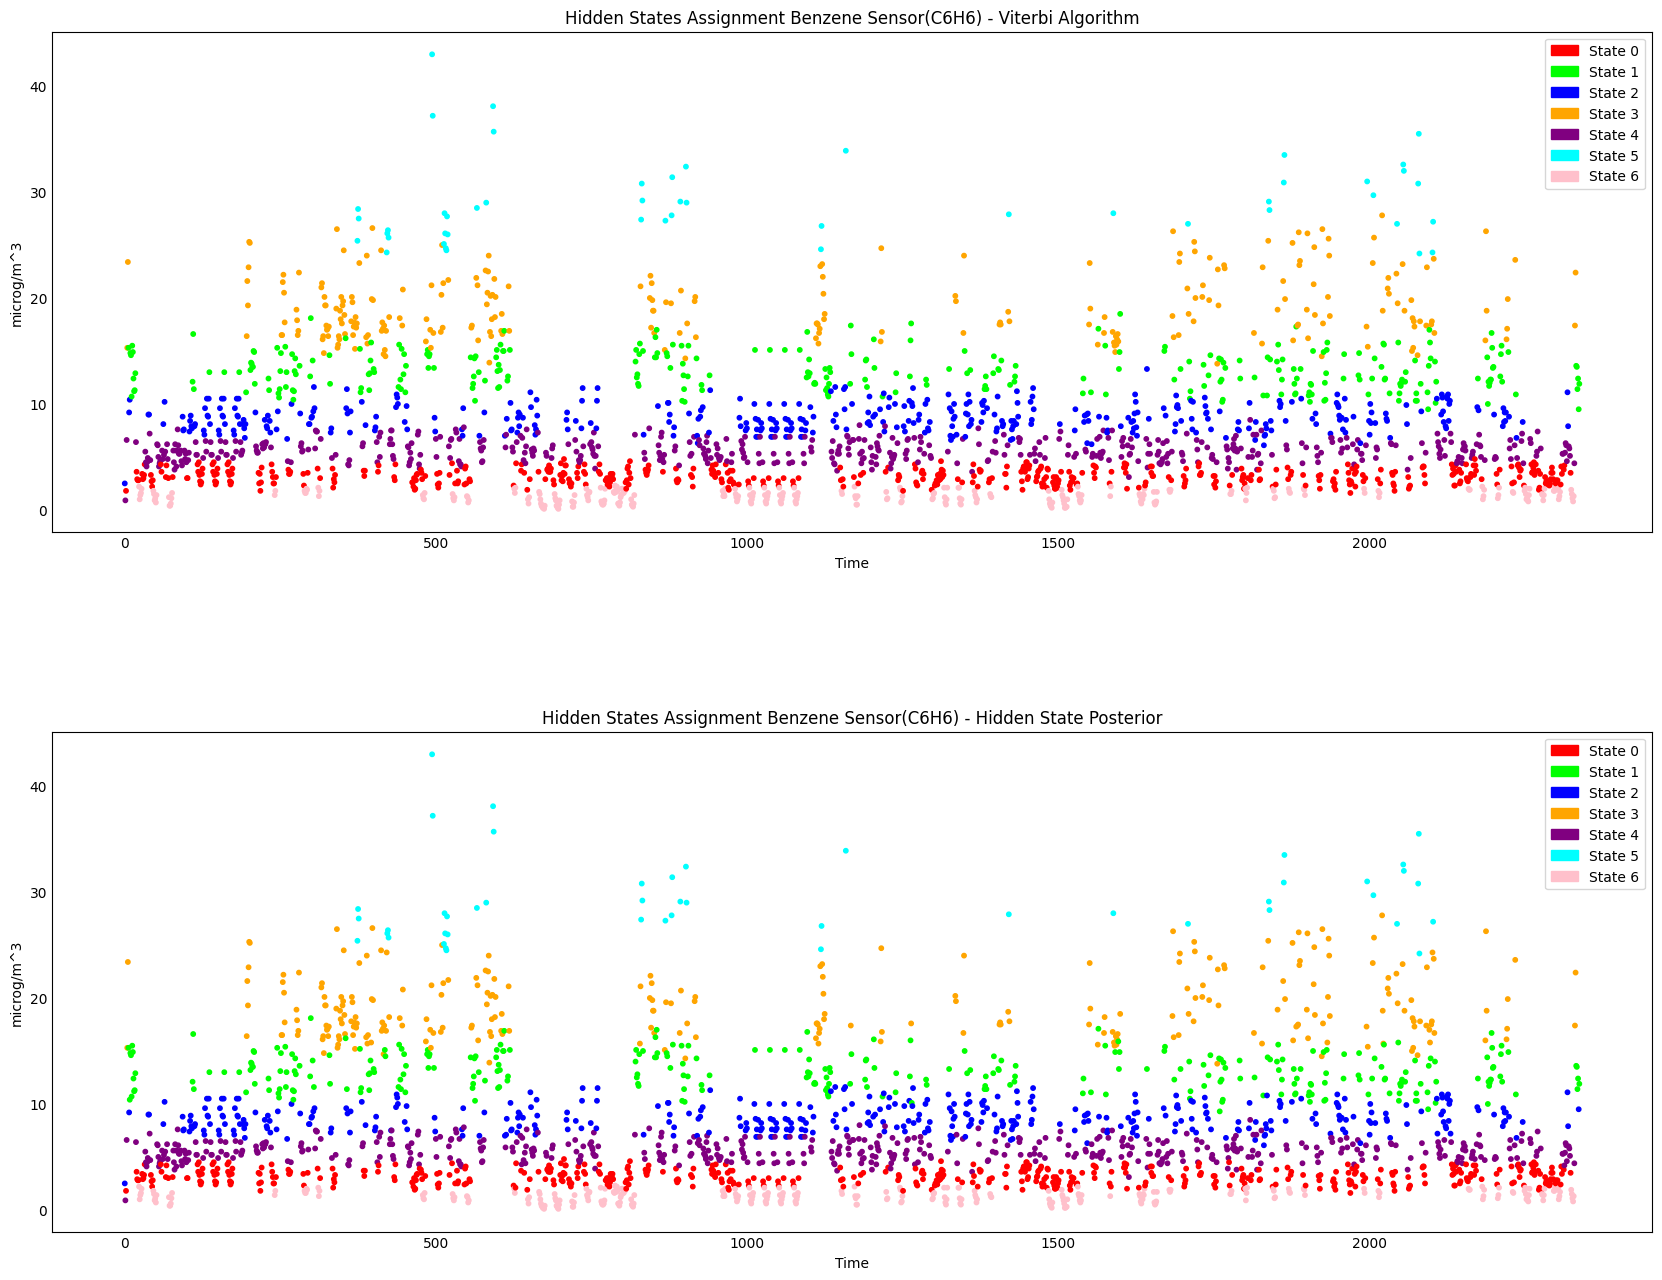

In [ ]:
# for the plots use scatter and colors and plot also a single line (- - - -) for each states (of course use the same colour)
states = 7

color_dict = {
    0: '#FF0000', 
    1: '#00FF00', 
    2: '#0000FF', 
    3: '#FFA500',  
    4: '#800080',
    5: '#00FFFF',
    6: '#FFC0CB'
}

labels = [f'State {i}' for i in range(states)]

legend = [mpatches.Patch(color=color_dict[i], label=labels[i]) for i in range(states)]

mps_colors = []
v_colors = []
for i, c in enumerate(subseq):
  v_colors.append(color_dict[v_states[i]])
  mps_colors.append(color_dict[mps_states[i]])

# plot
fig, ax = plt.subplots(2, 1, figsize = (20,15))

ax[0].set_title("Hidden States Assignment Benzene Sensor(C6H6) - Viterbi Algorithm")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("microg/m^3")
ax[0].scatter(data.index[0: subseq_size], subseq, s=10, c=v_colors)
ax[0].legend(handles=legend)

ax[1].set_title("Hidden States Assignment Benzene Sensor(C6H6) - Hidden State Posterior")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("microg/m^3")
ax[1].scatter(data.index[0: subseq_size], subseq, s=10, c=mps_colors)
ax[1].legend(handles=legend)

ax[0].grid(False)
ax[1].grid(False)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

## Appendix
Plot Transition matrix of the model

In [ ]:
def plot_transition_matrix(model, n_components, model_name):
    transition_matrix = model.transmat_

    # Plot the transition matrix
    plt.figure(figsize=(6, 4))
    plt.imshow(transition_matrix, interpolation='nearest', cmap='Blues')
    plt.title(f'HMM Transition Matrix with {n_components} states ({model_name})')
    plt.colorbar(label='Probability')

    for i in range(transition_matrix.shape[0]):
        for j in range(transition_matrix.shape[1]):
            plt.text(j, i, '{:.4f}'.format(transition_matrix[i, j]), ha="center", fontsize=6, color='black')
    
    plt.grid(False)
    plt.xticks(np.arange(n_components), labels=np.arange(n_components))
    plt.yticks(np.arange(n_components), labels=np.arange(n_components))
    plt.xlabel('To State')
    plt.ylabel('From State')
    plt.show()

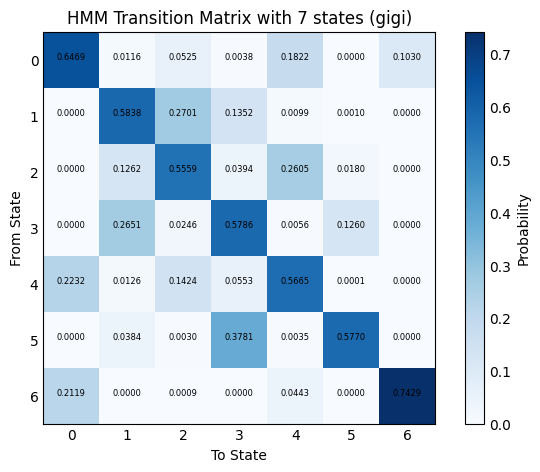

In [ ]:
plot_transition_matrix(gauss_model, 7, 'gigi')